In [2]:
@time using Plots
@time using Images
@time using ColorSchemes
@time using StatsBase
@time using LsqFit

  0.156201 seconds (129.10 k allocations: 6.447 MiB)
  0.000119 seconds (286 allocations: 15.250 KiB)
  0.000099 seconds (226 allocations: 12.219 KiB)
  0.000115 seconds (406 allocations: 21.344 KiB)
  0.000131 seconds (316 allocations: 16.766 KiB)


In [3]:
printArray(arr) = Base.print_matrix(IOContext(stdout, :limit => true), arr)

printArray (generic function with 1 method)

In [4]:
function neighbourIndices(nType::Int64, rad::Int64)
    indices = []
    if(nType == 0)
        indices = vcat([[i, 0] for i in -rad:rad], [[0, j] for j in -rad:rad])
    elseif(nType == 1)
        indices = [[i, j] for i in -rad:rad for j in -rad:rad]
    elseif(nType == 2)
        indices = [[i, j] for j in -rad:rad for i in (abs(j) - rad):(rad - abs(j))]
    end
    
    indices = [CartesianIndex(ind...) for ind in setdiff(indices, [[0,0]])]
end

neighbourIndices (generic function with 1 method)

In [5]:
function colormap(z0, cType)
    if cType == 1
        colors = range(RGB{N0f8}(0.0,0.0,0.0), stop=RGB{N0f8}(0,0.8,0.8), length = z0+5)
    end
    
    cmap = Dict(zip(0:z0+4, colors))
end

colormap (generic function with 1 method)

In [6]:
function setInitConditions(grid, init, z0, indices)
    if(init[1] == "random")
        for ind in indices
            grid[ind] = rand(0:z0-1 .|> Int8)
        end
        
    elseif(init[1] == "uniform")
        grid[indices] .+= init[2]
    end
    
    return
end

setInitConditions (generic function with 1 method)

In [7]:
function makegif(frames, z0, nsteps, fname, pType)
    if(pType == "h") #heatmap
        cmap = colormap(z0+4, 1)
        animGIF = @animate for i ∈ 1:nsteps 
            plot([cmap[p] for p in frames[i]])
        end
        gif(animGIF, fname, fps = 15)
        
    elseif(pType == "w") #wireframe
        animGIF = @animate for i ∈ 1:nsteps 
            plot(frames[i], st = :wireframe, zlims = (0, z0+4), camera = (-30, 35))
        end
        gif(animGIF, fname, fps = 15)        
    end
end

makegif (generic function with 1 method)

In [ ]:
function Sandpile(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
    sandbox = zeros(Int8, (n + 2*rad, n + 2*rad)) #main simulation grid
    frames = [] #stores each frame
    
    relNeighbour = neighbourIndices(2, rad) #relative index of neighbours
    indices = [CartesianIndex(i,j) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad)] #accessible nodes
    borders = filter(x -> !(x in indices), CartesianIndices(sandbox)) #inaccessible nodes /fixed BC
    
    #initial conditions
    setInitConditions(sandbox, init, z0, indices)
    
    #boundary conditions; fixed
    sandbox[borders] .= bValue
    
    prev = copy(sandbox) #copy of the grid
    push!(frames, copy(sandbox))
    
    for k in 2:nsteps
        
        #external driving
        if (sandbox[drop...] < z0) 
            sandbox[drop...] += 1
            prev[drop...] += 1
        end
        
        for index in indices
            if(prev[index] >= z0)
                sandbox[index] -= 4
                sandbox[relNeighbour .|> x-> x + index] .+= 1
            end
        end
        
        #boundary conditions
        sandbox[borders] .= bValue
        
        prev = copy(sandbox)
        push!(frames, copy(sandbox))
        
    end
    
    if(anim) makegif(frames, z0, nsteps, fname, pType) end
    
    return frames
end

In [ ]:
n = 25
z0 = 4
rad = 1
nsteps = 250
pType = "h"
anim = true
fname = "outputs/sandpile3.gif"
init = ["uniform", 2]
bValue = 0
drop = [n÷2 + rad + 1, n÷2 + rad + 1]
@time d = Sandpile(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
()

In [ ]:
function SandPileData(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
    sandbox = zeros(Int8, (n + 2*rad, n + 2*rad)) #main simulation grid
    frames = [] #stores each frame
    nData = zeros(Int64, (nsteps, 3)) #1-number of sites toppled; 2-number of topplings; 3-time till relaxation
    toppleCount = zeros(Int64, 500) #counts topplings every loop
    dropFlag = false #flag for new drop
    dropCount = 1 #keeps track of how many drops have happened
    
    relNeighbour = neighbourIndices(2, rad) #relative index of neighbours
    indices = [CartesianIndex(i,j) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad)] #accessible nodes
    borders = filter(x -> !(x in indices), CartesianIndices(sandbox)) #inaccessible nodes /fixed BC
    
    #initial conditions
    setInitConditions(sandbox, init, z0, indices)
    
    #boundary conditions; fixed
    sandbox[borders] .= bValue
    
    prev = copy(sandbox) #copy of the grid
    push!(frames, copy(sandbox))
    
    k = 1 #index for loop
    while(dropCount < nsteps)
        k += 1
        
        #topple check
        for index in indices
            if(prev[index] >= z0)
                sandbox[index] -= 4
                sandbox[relNeighbour .|> x-> x + index] .+= 1
                toppleCount[k] += 1
            end
        end
        
        nData[dropCount, 3] += 1 #number of timesteps till relaxation
        
        #boundary conditions
        sandbox[borders] .= bValue
        
        #external driving
        if (toppleCount[k] == 0)
            dropFlag = true
            nData[dropCount, 2] = sum(toppleCount[1:k]) 
            dropCount += 1
            toppleCount .= 0
            k = 1
        end
        
        if (dropFlag)
            dropPoint = rand(rad+1:n+rad, 2)
            sandbox[dropPoint...] += 1
            prev[dropPoint...] += 1
            
            dropFlag = false
        end
        
        #prep for next iteration
        prev = copy(sandbox)
        push!(frames, copy(sandbox))
        
    end
    
    if(anim) makegif(frames, z0, nsteps, fname, pType) end
    
    return nData
end

In [ ]:
n = 51
z0 = 4
rad = 1
nsteps = 500
pType = "h"
anim = false
fname = "outputs/sandpile3.gif"
init = ["uniform", 3]
bValue = 0
drop = [n÷2 + rad + 1, n÷2 + rad + 1]
@time data = SandPileData(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
()

# Data collection edit

In [8]:
function SandPileDataFinal(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
    sandbox = zeros(Int8, (n + 2*rad, n + 2*rad)) #main simulation grid
    #frames = [] #stores each frame
    nData = zeros(Int64, (nsteps, 3)) #1-number of sites toppled; 2-number of topplings; 3-time till relaxation
    toppleCount = zeros(Int64, 2) #counts topplings every loop
    dropFlag = false #flag for new drop
    dropCount = 1 #keeps track of how many drops have happened
    areaMap = copy(sandbox) #notes toppled sites
    
    relNeighbour = neighbourIndices(2, rad) #relative index of neighbours
    indices = [CartesianIndex(i,j) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad)] #accessible nodes
    borders = filter(x -> !(x in indices), CartesianIndices(sandbox)) #inaccessible nodes /fixed BC
    
    #initial conditions
    setInitConditions(sandbox, init, z0, indices)
    
    #boundary conditions; fixed
    sandbox[borders] .= bValue
    
    prev = copy(sandbox) #copy of the grid
    #push!(frames, copy(sandbox))
    
    while(dropCount < nsteps)
        toppleCount[1] = toppleCount[2]
        
        #topple check
        for index in indices
            if(prev[index] >= z0)
                sandbox[index] -= 4
                sandbox[relNeighbour .|> x-> x + index] .+= 1
                toppleCount[2] += 1
                areaMap[index] = 1
            end
        end
        
        nData[dropCount, 3] += 1 #number of timesteps till relaxation
        
        #boundary conditions
        sandbox[borders] .= bValue
        
        #external driving
        if (toppleCount[1] == toppleCount[2])
            dropFlag = true
            nData[dropCount, 2] += toppleCount[1]
            nData[dropCount, 1] += count(x->x==1, areaMap)
            areaMap .= 0
            dropCount += 1
            toppleCount .= 0
        end
        
        if (dropFlag)
            dropPoint = rand(rad+1:n+rad, 2)
            sandbox[dropPoint...] += 1
            prev[dropPoint...] += 1
            
            dropFlag = false
        end
        
        #prep for next iteration
        prev = copy(sandbox)
        #push!(frames, copy(sandbox))
        
    end
    
    if(anim) makegif(frames, z0, nsteps, fname, pType) end
    
    return nData
end

SandPileDataFinal (generic function with 1 method)

In [14]:
n = 50
z0 = 4
rad = 1
nsteps = 10^6
pType = "h"
anim = false
fname = "outputs/sandpileFinal3.gif"
init = ["random"]
bValue = 0
drop = [n÷2 + rad + 1, n÷2 + rad + 1]
@time datapoints = SandPileDataFinal(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
()

293.430460 seconds (1.08 G allocations: 79.839 GiB, 4.57% gc time)


()

Binned #1: -1.048+0.005


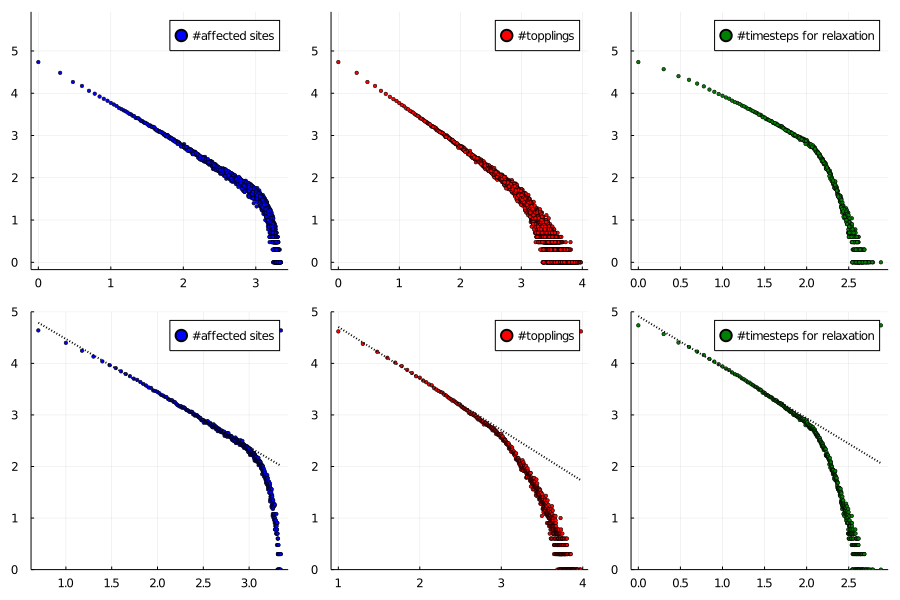

Binned #2: -0.999+0.01
Binned #3: -0.99+0.009


In [16]:
data = copy(datapoints[1:end - 1, :])
data[:, 3] .-= 1

plts = []
cols = [:blue, :red, :green]
lab = ["#affected sites","#topplings", "#timesteps for relaxation"]
#for fitting
starts = [2, 2, 2]
stops = [100, 20, 40]
m(x, p) = p[1] .* x .+ p[2]
p0 = [-1.0, 5]
#nBins = sqrt(length(data[:, 1])) |> floor
nBins = 1000

for i in [1,2,3]
    xyax = countmap(data[:, i])
    xax = keys(xyax) .|> log10
    yax = values(xyax) .|> log10
    
    xax = xax[2:end] #remove first -inf (0)
    yax = yax[2:end] 
    
    cplot = scatter(xax, yax, color = cols[i], label = lab[i], markersize = 2, markerstrokewidth = 0.5)
    push!(plts, cplot)
end

for i in [1,2,3]
    h = fit(Histogram, data[:, i], nbins = nBins)
    xax = h.edges[1]  .|> log10
    yax = h.weights .|> log10    
    
    xax = xax[2:end] #remove first -inf (0)
    yax = yax[2:end] 
        
    res = curve_fit(m, xax[starts[i]:stops[i]], yax[starts[i]:stops[i]], p0)
    mres(x) = m(x, res.param)
    println("Binned #" * string(i) * ": " * string(round(res.param[1], digits = 3))*"+"*string(round(stderror(res)[1],digits = 3)))
    
    cplot = scatter(xax, yax, ylims = (0, 5), color = cols[i], label = lab[i], markersize = 2, markerstrokewidth = 0.5)
    plot!(xax, mres.(xax), linestyle=:dot, lw = 2, color = :black, label = "")
    push!(plts, cplot)
    
end

display(plot(plts..., size = (900,600), layout = (2,3)))

# Attempt at 3D version

In [ ]:
function SandPileData3D(n, z0, rad, nsteps, pType, anim, fname, init, bValue, drop)
    sandbox = zeros(Int8, (n + 2*rad, n + 2*rad, n + 2*rad)) #main simulation grid
    #frames = [] #stores each frame
    nData = zeros(Int64, (nsteps, 3)) #1-number of sites toppled; 2-number of topplings; 3-time till relaxation
    toppleCount = zeros(Int64, 2) #counts topplings every loop
    dropFlag = false #flag for new drop
    dropCount = 1 #keeps track of how many drops have happened
    areaMap = copy(sandbox) #notes toppled sites
    
    relNeighbour = [CartesianIndex(ind...) for ind in [(1,0,0), (0,1,0), (0,0,1), (-1,0,0), (0,-1,0), (0,0,-1)]] #relative index of neighbours
    indices = [CartesianIndex(i,j,k) for i in (rad+1):(n+rad) for j in (rad+1):(n+rad) for k in (rad+1):(n+rad)] #accessible nodes
    borders = filter(x -> !(x in indices), CartesianIndices(sandbox)) #inaccessible nodes /fixed BC
    
    #initial conditions
    for ind in indices
            grid[ind] = rand(0:z0-1 .|> Int8)
        end
    #boundary conditions; fixed
    sandbox[borders] .= bValue
    
    prev = copy(sandbox) #copy of the grid
    #push!(frames, copy(sandbox))
    
    while(dropCount < nsteps)
        toppleCount[1] = toppleCount[2]
        
        #topple check
        for index in indices
            if(prev[index] >= z0)
                sandbox[index] -= 6
                sandbox[relNeighbour .|> x-> x + index] .+= 1
                toppleCount[2] += 1
                areaMap[index] = 1
            end
        end
        
        nData[dropCount, 3] += 1 #number of timesteps till relaxation
        
        #boundary conditions
        sandbox[borders] .= bValue
        
        #external driving
        if (toppleCount[1] == toppleCount[2])
            dropFlag = true
            nData[dropCount, 2] += toppleCount[1]
            nData[dropCount, 1] += count(x->x==1, areaMap)
            areaMap .= 0
            dropCount += 1
            toppleCount .= 0
        end
        
        if (dropFlag)
            dropPoint = rand(rad+1:n+rad, 3)
            sandbox[dropPoint...] += 1
            prev[dropPoint...] += 1
            
            dropFlag = false
        end
        
        #prep for next iteration
        prev = copy(sandbox)
        #push!(frames, copy(sandbox))
        
    end
    
    if(anim) makegif(frames, z0, nsteps, fname, pType) end
    
    return nData
end